# Сжатие выходного диапазона

In [1]:
import math
import torch

In [2]:
math.tanh(-2.2)

-0.9757431300314515

In [3]:
math.tanh(0.1)

0.09966799462495582

In [4]:
math.tanh(2.5)

0.9866142981514303

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

# 6.2.1. Использование метода __call__ вместо метода forward

In [6]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

t_u и t_c — два одномерных тензора размером B. Благодаря транслированию мы могли записать нашу линейную
модель в виде w * x + b, где w и b — два скалярных параметра. И все это благодаря
наличию лишь одного входного признака: если бы их было два, нам пришлось бы
добавить еще одно измерение, чтобы превратить одномерный тензор в матрицу,
с примерами данных по строкам и признакам по столбцам.

Именно это нам и нужно сделать при переходе на использование nn.Linear.
Меняем форму наших входных сигналов размером B на B × Nвх, где Nвх = 1. Это
можно легко сделать при помощи метода unsqueeze:

In [7]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [8]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 8,  6,  3,  5,  9,  1,  7,  4, 10]), tensor([0, 2]))

In [9]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [10]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[2.3067],
        [3.4216]], grad_fn=<AddmmBackward0>)

# 6.2.2. Обратно к линейной модели

Конструктор nn.Linear принимает
три аргумента: число входных признаков, число выходных признаков и булево
значение, указывающее, включает линейная модель смещение или нет (здесь
по умолчанию True):

In [11]:
linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-0.4373],
        [-0.5891]], grad_fn=<AddmmBackward0>)

Количество признаков в нашем случае просто отражает размер входного и выходного тензоров, 1 и 1. Если использовать в качестве входных данных и температуру, и атмосферное давление, например, получилось бы два входных признака
и один выходной. Как мы увидим, в более сложных моделях с несколькими промежуточными модулями количество признаков связано с мощностью модели.
Итак, у нас есть экземпляр nn.Linear с одним входным и одним выходным признаком. Такая модель требует одного весового коэффициента и одного смещения:

In [12]:
linear_model.weight

Parameter containing:
tensor([[-0.0675]], requires_grad=True)

In [13]:
linear_model.bias

Parameter containing:
tensor([-0.1964], requires_grad=True)

Вызываем модуль с каким-нибудь входным сигналом:

In [14]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2639], grad_fn=<ViewBackward0>)

# Группировка входных данных в батчи
Все модули в nn ориентированы на генерацию выходных сигналов сразу для
батча из нескольких входных сигналов. Следовательно, если нам нужно выполнить nn.Linear для десяти примеров данных, можно создать входной тензор
размером B × Nвх, где B — размер батча, а Nвх — число входных признаков, и пропустить его один раз через модель. Например:

In [15]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639],
        [-0.2639]], grad_fn=<AddmmBackward0>)

А теперь преобразуем код обучения. Прежде всего, заменим нашу самодельную модель на nn.Linear(1,1), после чего передадим параметры линейной
модели оптимизатору:

In [16]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

Ранее мы сами должны были создавать параметры и передавать их в качестве
первого аргумента методу optim.SGD. Теперь можно воспользоваться методом
parameters, чтобы запросить у любого экземпляра nn.Module список параметров
его или любого из его подмодулей:

In [17]:
linear_model.parameters()

<generator object Module.parameters at 0x783d3734f990>

In [18]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.9957]], requires_grad=True),
 Parameter containing:
 tensor([0.3288], requires_grad=True)]

Взглянем теперь на сам цикл обучения:

In [19]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        train_t_p = model(t_u_train)
        loss_train = loss_fn(train_t_p, t_c_train)

        valid_t_p = model(t_u_val)
        loss_valid = loss_fn(valid_t_p, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
             print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
             f" Validation loss {loss_valid.item():.4f}")

Практически ничего не поменялось, за исключением того, что теперь не нужно
передавать params явным образом в model, поскольку параметры модели содержатся внутри нее самой.
Остался еще один, последний элемент torch.nn, которым мы можем воспользоваться: функция потерь. Разумеется, nn включает несколько распространенных
функций потерь, одна из которых — nn.MSELoss, ее мы раньше описали в качестве
нашей loss_fn. Функции потерь в nn — тоже подклассы nn.Module, так что мы
создадим еще один экземпляр и вызовем его как функцию. В нашем случае мы
заменяем самодельную loss_fn:

In [20]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model=linear_model,
              loss_fn=nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val)
print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 290.9656, Validation loss 165.1122
Epoch 1000, Training loss 4.0384, Validation loss 4.3845
Epoch 2000, Training loss 3.2333, Validation loss 2.1932
Epoch 3000, Training loss 3.2100, Validation loss 1.9127

Parameter containing:
tensor([[5.2378]], requires_grad=True)
Parameter containing:
tensor([-16.5773], requires_grad=True)


# 6.3.1. Замена линейной модели

Модуль nn предоставляет удобный способ соединения модулей цепочкой с помощью контейнера nn.Sequential:

In [24]:
seq_model = nn.Sequential(
    nn.Linear(1, 13), # Значение 13 взято произвольно. Мы хотели, чтобы размер отличался от других размеров имеющихся у нас тензорных форм
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

# 6.3.2. Просматриваем информацию о параметрах

При вызове model.parameters() собираются weight и bias как из первого, так
и из второго линейного модуля. В данном случае будет поучительно изучить
параметры, отобразив на экран информацию об их форме:


In [26]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

Несколько замечаний относительно параметров nn.Module. При просмотре
информации о параметрах модели, состоящей из нескольких модулей, не помешает возможность идентифицировать параметры по названию. Для этой цели
предназначен метод named_parameters:

In [29]:
for name, parameter in seq_model.named_parameters():
  print(name, parameter.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Названия модулей в Sequential представляют собой просто порядковые номера
модулей в списке аргументов. Что любопытно, Sequential1 также принимает на
входе OrderedDict, в котором можно указать название каждого из передаваемых
Sequential модулей:

In [31]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

Это дает возможность дать подмодулям более понятные названия:

In [32]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Обращаться к конкретным объектам Parameter можно путем указания подмодулей в качестве атрибутов:

In [33]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0748], requires_grad=True)

Это очень удобно для просмотра параметров или их градиентов, например для
мониторинга градиентов во время обучения, какмы делали в начале данной главы.
Допустим, мы хотели бы вывести на экран градиенты параметра weight линейной
части скрытого слоя. Запускаемцикл обучения для новоймодели нейронной сети,
после чего смотрим на получившиеся градиенты после последней эпохи:

In [34]:
optimizer = optim.SGD(seq_model.parameters() , lr=1e-3)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val
              )

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 202.4215, Validation loss 111.4717
Epoch 1000, Training loss 5.2168, Validation loss 1.3563
Epoch 2000, Training loss 2.8537, Validation loss 1.6797
Epoch 3000, Training loss 1.6452, Validation loss 3.2324
output tensor([[ 2.3233],
        [13.2239]], grad_fn=<AddmmBackward0>)
answer tensor([[ 0.5000],
        [15.0000]])
hidden tensor([[ 0.0754],
        [ 0.0424],
        [ 0.0451],
        [-0.0416],
        [ 0.0013],
        [ 0.0228],
        [ 0.0461],
        [ 0.0599]])


# 6.3.3. Сравнение с линейной моделью

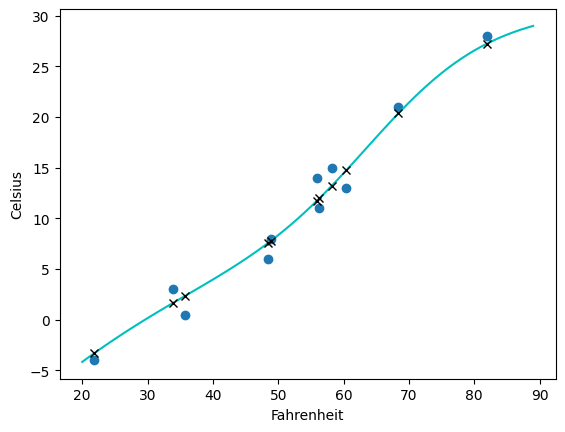

In [42]:
import matplotlib.pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius");

График нейросетевой модели со входными данными (кружки) и выходным
сигналом модели (X). Непрерывная кривая отражает поведение модели
в промежутках между примерами данных

# 6.5. Упражнения

1. Поэкспериментируйте с количеством скрытых нейронов в нашей простой
нейросетевой модели, а также со скоростью обучения.

  А. Какие изменения приводят к повышению линейности выходного сигнала
  модели?

  Б. Можете ли вы добиться явного переобучения модели?

2. Третья по сложности задача физики — выбор подходящего вина для празднования открытий. Загрузите данные о винах из главы 4 и создайте новую
модель с соответствующим количеством входных параметров.

  А. Сколько времени занимает обучение по сравнению с задачей о термометре?

  Б. Можете ли вы объяснить, какие факторы влияют на длительность обучения?

  В. Можете ли вы добиться снижения потерь при обучении на этом наборе
данных?

  Г. Как построить график для этого набора данных?

In [78]:
seq_model = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

In [85]:
optimizer = optim.SGD(seq_model.parameters() , lr=1e-4)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model = seq_model,
              loss_fn = nn.MSELoss(),
              t_u_train = t_un_train,
              t_u_val = t_un_val,
              t_c_train = t_c_train,
              t_c_val = t_c_val
              )

print('output', seq_model(t_un_val))
print('answer', t_c_val)

Epoch 1, Training loss 19.2155, Validation loss 13.2258
Epoch 1000, Training loss 11.4311, Validation loss 5.8333
Epoch 2000, Training loss 7.9635, Validation loss 3.0085
Epoch 3000, Training loss 6.2205, Validation loss 1.8172
output tensor([[ 2.1292],
        [14.0108]], grad_fn=<AddmmBackward0>)
answer tensor([[ 0.5000],
        [15.0000]])


In [86]:
t_range = torch.arange(20.,90.).unsqueeze(1)

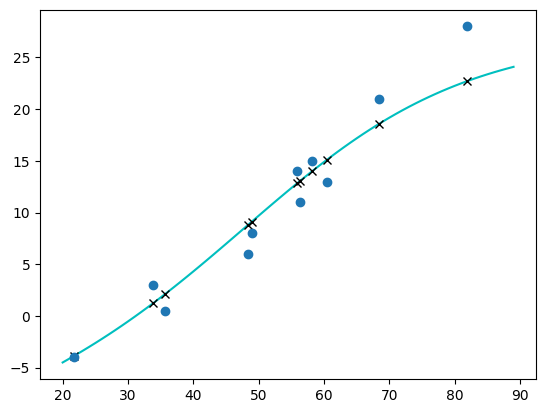

In [87]:
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-');
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')